# plot_hysteresis.ipynb

Author: Robert M. Frost

University of Oklahoma

Created: 12 September 2023

Purpose: Plot roll factor $R$ and length scale ratios $\lambda_{x'}^{w} / \lambda_{y'}^{w}$ vs $-z_i / L$

In [62]:
import sys
sys.path.append("/home/rfrost/LES-utils/")

import seaborn
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESutils import load_full
import seaborn

In [63]:
# location of netCDF simulation output
output = "/home/rfrost/simulations/nc/"
# name of simulation
sims = ["full_step_6", "full_step_9", "full_step_12", "full_step_15"]

# timesteps
t0 = 576000
t1 = 1152000
# start/end times in hours
t0hr = t0 * 0.05 / 3600
t1hr = t1 * 0.05 / 3600

# height indice (0=0.10, 1=0.25, 2=0.50)
hidx = 1

# timesteps to average over
avg = 12

In [64]:
# read in roll factor
r6 = xr.open_dataarray(f"{output}full_step_6/rollfactor.nc")
r9 = xr.open_dataarray(f"{output}full_step_9/rollfactor.nc")
r12 = xr.open_dataarray(f"{output}full_step_12/rollfactor.nc")
r15 = xr.open_dataarray(f"{output}full_step_15/rollfactor.nc")
# xarray dataset to store
roll = xr.Dataset(
    data_vars=dict(
        ug6=(["height", "time"], r6.values),
        ug9=(["height", "time"], r9.values),
        ug12=(["height", "time"], r12.values),
        ug15=(["height", "time"], r15.values)
    ),
    coords=dict(
        heights=r6.heights.values,
        time=r6.time.values)
)
# convert time to hours
roll["time"] = roll.time / 3600 + t0hr

# read in length scales
ls6 = xr.open_dataset(f"{output}full_step_6/{t0}_{t1}_length_scale_rot.nc")
ls6 = (ls6.rolls / ls6.normal.rolling(time=avg).mean())
ls9 = xr.open_dataset(f"{output}full_step_9/{t0}_{t1}_length_scale_rot.nc")
ls9 = (ls9.rolls / ls9.normal).rolling(time=avg).mean()
ls12 = xr.open_dataset(f"{output}full_step_12/{t0}_{t1}_length_scale_rot.nc")
ls12 = (ls12.rolls / ls12.normal).rolling(time=avg).mean()
ls15 = xr.open_dataset(f"{output}full_step_15/{t0}_{t1}_length_scale_rot.nc")
ls15 = (ls15.rolls / ls15.normal).rolling(time=avg).mean()
# convert time to hours
ls6["time"] = ls6.time / 3600 + t0hr

# read in stats
s_all = []
for sim in sims:
    dnc = f"{output}{sim}/"
    s = xr.open_dataset(f"{dnc}{t0}_{t1}_stats.nc")
    s["time"] = s.time / 3600 + t0hr
    s["zi_L"] = s.zi_L.rolling(time=avg).mean()
    s_all.append(s)

In [65]:
heights = roll.heights
ntime = s.time.size

In [66]:
# array to hold indicies of z/zi
jz = np.zeros((len(sims),ntime))

for i, s in enumerate(s_all):
    for jt in range(ntime):
        jz[i,jt] = abs(s_all[i].z/s_all[i].zi[jt] - heights[hidx]).argmin()

jz = jz.astype(int)

In [67]:
ts6, ts9, ts12, ts15 = [np.zeros(ntime) for _ in range(4)]
for jt in range(ntime):
    ts6[jt] = ls6.isel(z=jz[0,jt], time=jt)
    ts9[jt] = ls9.isel(z=jz[1,jt], time=jt)
    ts12[jt] = ls12.isel(z=jz[2,jt], time=jt)
    ts15[jt] = ls15.isel(z=jz[3,jt], time=jt)

In [68]:
# xarray dataset to store ls
ls = xr.Dataset(
    data_vars=dict(
        ug6=(["time"], ts6),
        ug9=(["time"], ts9),
        ug12=(["time"], ts12),
        ug15=(["time"], ts15),
    ),
    coords=dict(
        time=ls6.time.values
        )
)

In [69]:
# plotting setup
rc('font',weight='normal',size=15,family='serif',serif='Times New Roman')
rc('text',usetex='True')
rc('figure',facecolor='white')
cmap = seaborn.color_palette("Spectral", as_cmap=True)
colors2 = seaborn.color_palette("rocket_r", len(sims))

## Plot $\lambda_w^{x'} / \lambda_w^{y'}$ vs $-z_i / L$

Text(0.0, 1.0, '(d) $U_g$ = 15 [m s$^{-1}$]')

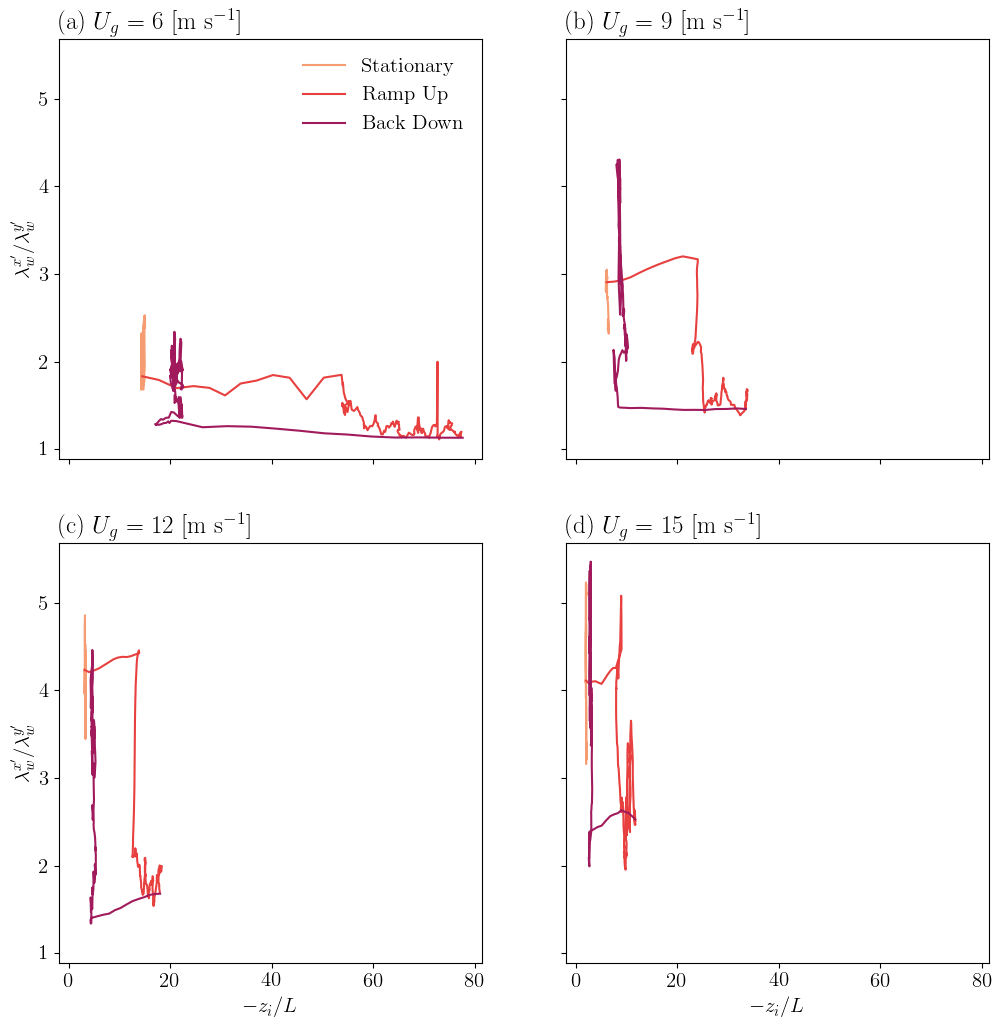

In [70]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2, ncols=2, 
                       sharex=True, sharey=True)

# 6 m/s
ax[0,0].plot(s_all[0].zi_L[:144], ls.ug6[:144], 
             label="Stationary", 
             c=colors2[0])
ax[0,0].plot(s_all[0].zi_L[144:360], ls.ug6[144:360], 
             label="Ramp Up", 
             c=colors2[1])
ax[0,0].plot(s_all[0].zi_L[360:], ls.ug6[360:], 
             label="Back Down", 
             c=colors2[2])

# 9 m/s
ax[0,1].plot(s_all[1].zi_L[:144], ls.ug9[:144], c=colors2[0])
ax[0,1].plot(s_all[1].zi_L[144:360], ls.ug9[144:360], c=colors2[1])
ax[0,1].plot(s_all[1].zi_L[360:], ls.ug9[360:], c=colors2[2])

# 12 m/s
ax[1,0].plot(s_all[2].zi_L[:144], ls.ug12[:144], c=colors2[0])
ax[1,0].plot(s_all[2].zi_L[144:360], ls.ug12[144:360], c=colors2[1])
ax[1,0].plot(s_all[2].zi_L[360:], ls.ug12[360:], c=colors2[2])

# 15 m/s
ax[1,1].plot(s_all[3].zi_L[:144], ls.ug15[:144], c=colors2[0])
ax[1,1].plot(s_all[3].zi_L[144:360], ls.ug15[144:360], c=colors2[1])
ax[1,1].plot(s_all[3].zi_L[360:], ls.ug15[360:], c=colors2[2])

ax[0,0].legend(frameon=False, loc="upper right")

for i, iax in enumerate(ax[:,0]):
    iax.set_ylabel("$\lambda_{w}^{x'} / \lambda_{w}^{y'}$")
for i, iax in enumerate(ax[1,:]):
    iax.set_xlabel("$-z_i / L$")

ax[0,0].set_title(f"(a) $U_g$ = {sims[0][10:]} [m s$^{{-1}}$]", loc="left")
ax[0,1].set_title(f"(b) $U_g$ = {sims[1][10:]} [m s$^{{-1}}$]", loc="left")
ax[1,0].set_title(f"(c) $U_g$ = {sims[2][10:]} [m s$^{{-1}}$]", loc="left")
ax[1,1].set_title(f"(d) $U_g$ = {sims[3][10:]} [m s$^{{-1}}$]", loc="left")

# fig.tight_layout

## Plot $R$ vs $-z_i / L$

Text(0.0, 1.0, '(d) $U_g$ = 15 [m s$^{-1}$]')

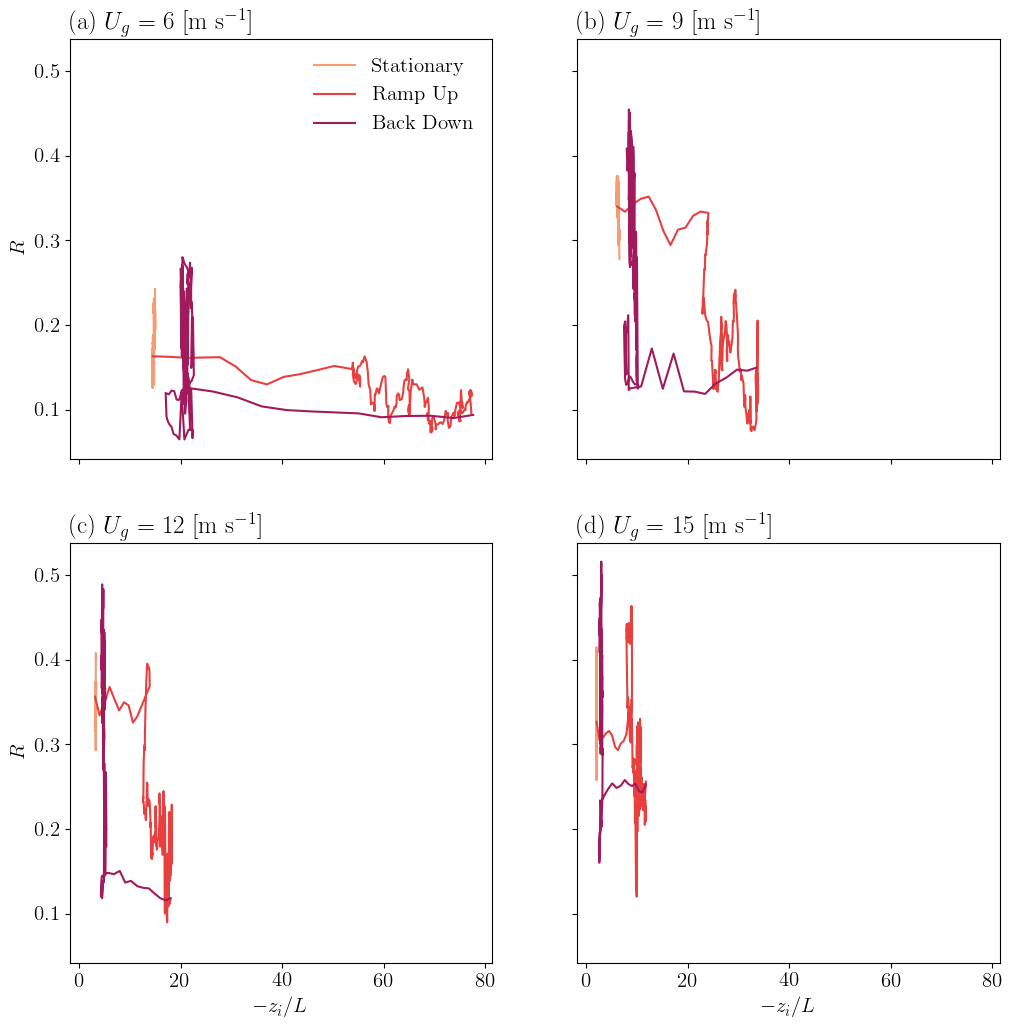

In [71]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2, ncols=2, 
                       sharex=True, sharey=True)

# 6 m/s
ax[0,0].plot(s_all[0].zi_L[:144], roll.ug6[hidx,:144], 
             label="Stationary", c=colors2[0])
ax[0,0].plot(s_all[0].zi_L[144:360], roll.ug6[hidx,144:360], 
             label="Ramp Up", c=colors2[1])
ax[0,0].plot(s_all[0].zi_L[360:], roll.ug6[hidx,360:], 
             label="Back Down", c=colors2[2])

# 9 m/s
ax[0,1].plot(s_all[1].zi_L[:144], roll.ug9[hidx,:144], c=colors2[0])
ax[0,1].plot(s_all[1].zi_L[144:360], roll.ug9[hidx,144:360], c=colors2[1])
ax[0,1].plot(s_all[1].zi_L[360:], roll.ug9[hidx,360:], c=colors2[2])

# 12 m/s
ax[1,0].plot(s_all[2].zi_L[:144], roll.ug12[hidx,:144], c=colors2[0])
ax[1,0].plot(s_all[2].zi_L[144:360], roll.ug12[hidx,144:360], c=colors2[1])
ax[1,0].plot(s_all[2].zi_L[360:], roll.ug12[hidx,360:], c=colors2[2])

# 15 m/s
ax[1,1].plot(s_all[3].zi_L[:144], roll.ug15[hidx,:144], c=colors2[0])
ax[1,1].plot(s_all[3].zi_L[144:360], roll.ug15[hidx,144:360], c=colors2[1])
ax[1,1].plot(s_all[3].zi_L[360:], roll.ug15[hidx,360:], c=colors2[2])

ax[0,0].legend(frameon=False, loc="upper right")

for i, iax in enumerate(ax[:,0]):
    iax.set_ylabel("$R$")
for i, iax in enumerate(ax[1,:]):
    iax.set_xlabel("$-z_i / L$")

ax[0,0].set_title(f"(a) $U_g$ = {sims[0][10:]} [m s$^{{-1}}$]", loc="left")
ax[0,1].set_title(f"(b) $U_g$ = {sims[1][10:]} [m s$^{{-1}}$]", loc="left")
ax[1,0].set_title(f"(c) $U_g$ = {sims[2][10:]} [m s$^{{-1}}$]", loc="left")
ax[1,1].set_title(f"(d) $U_g$ = {sims[3][10:]} [m s$^{{-1}}$]", loc="left")

In [72]:
# fig, ax = plt.subplots(figsize=(8,8))

# # 6 m/s
# ax.plot(s_all[0].zi_L[:144], ls.ug6[:144],
#         c=colors2[0], ls=":")
# ax.plot(s_all[0].zi_L[144:360], ls.ug6[144:360],
#         c=colors2[0], ls="--")
# ax.plot(s_all[0].zi_L[360:], ls.ug6[360:], 
#         label=f"$U_g$ = {sims[0][10:]} [m s$^{{-1}}$]", 
#         c=colors2[0])

# # 9 m/s
# ax.plot(s_all[1].zi_L[:144], ls.ug9[:144],
#         c=colors2[1], ls=":")
# ax.plot(s_all[1].zi_L[144:360], ls.ug9[144:360],
#         c=colors2[1], ls="--")
# ax.plot(s_all[1].zi_L[360:], ls.ug9[360:], 
#         label=f"$U_g$ = {sims[1][10:]} [m s$^{{-1}}$]", 
#         c=colors2[1])

# # 12 m/s
# ax.plot(s_all[2].zi_L[:144], ls.ug12[:144],
#         c=colors2[2], ls=":")
# ax.plot(s_all[2].zi_L[144:360], ls.ug12[144:360],
#         c=colors2[2], ls="--")
# ax.plot(s_all[2].zi_L[360:], ls.ug12[360:], 
#         label=f"$U_g$ = {sims[2][10:]} [m s$^{{-1}}$]", 
#         c=colors2[2])

# # 15 m/s
# ax.plot(s_all[3].zi_L[:144], ls.ug15[:144],
#         c=colors2[3], ls=":")
# ax.plot(s_all[3].zi_L[144:360], ls.ug15[144:360],
#         c=colors2[3], ls="--")
# ax.plot(s_all[3].zi_L[360:], ls.ug15[360:], 
#         label=f"$U_g$ = {sims[3][10:]} [m s$^{{-1}}$]", 
#         c=colors2[3])

# ax.legend(frameon=False, loc="upper right")

# ax.set_ylabel("$\lambda_{w}^{x'} / \lambda_{w}^{y'}$")
# ax.set_xlabel("$-z_i / L$")